# Ruthenium experiment
This notebook illustrates how to use BiasCorrGP with LS-APC model for the source term for the inversion on the Ru106 dataset.

In [1]:
import numpy as np
import torch
import h5py
from IPython.display import display, Markdown

from src.biascorrgp.models import TripleGP_prior, TripleGP_posterior, lsapc_sourceTerm
from src.biascorrgp.data_handling.load_data import load_input_data, prepare_inversion_data
from src.biascorrgp.data_handling.training import create_training_data, normalized_lengthscales_same
from src.biascorrgp.utils.plotting import multi_L_curve, plot_source, plot_scatter_linear, plot_scatter_log, plot_predicted_shifts, concentration_plot_etex
from src.biascorrgp.utils.predict import prediction_data, predict_shifts

In [2]:
#Load and prepare the data
inp_data = load_input_data("data/Ruthenium/input_ruthenium_data.h5", xtrue=False)
inv_data = prepare_inversion_data(inp_data)

#create the training data - normalized locations and their mutual distances
train_X, lon_lat_scaler, time_scaler = create_training_data(inp_data)

In [3]:
#define the lengthscales for the GPs
real_space_lengthscale = 0.5 #best solution for ETEX
outputscale = 0.01 #best solution for ETEX
normed_l = normalized_lengthscales_same(real_space_lengthscale, lon_lat_scaler, time_scaler) #lengthscales scaled to normalized coordinates

#define the GP prior for bias correction
bc_prior = TripleGP_prior(train_X, normed_l, outputscale)

#define the GP posterior for bias correction
bc_posterior = TripleGP_posterior(inv_data.Dh, inv_data.Dv, inv_data.Dt, inv_data.M, sh = 1.0, sv = 1.0, st = 3.0) #create posterior with shift means initialized to zeros

#create the source term 
source = lsapc_sourceTerm(inv_data.M, gamma = 1.0, omega_opt=True) #precision omega is optimized together with the source term
source.reinit_alpha_beta(1e-1, 1e-1) #ruthenium specidic setting

In [4]:
#optimization loop
iter = 500
mse = [] #stores MSe values during the optimization
max_shift = [] #stores maximal shift during the optimization
oms = [] #stores omega values during the optimization - for convergence checking
totem = [] #stores the sum of the source term during the optimization - for convergence checking
with torch.no_grad():
    for it in range(iter):
        #inversion
        tildeM = bc_posterior.get_tildeM() #returns only inv_data.M for it < 50
        tildeMttildeM = bc_posterior.get_tildeMttildeM(tildeM) #returns only inv_data.M.T @ inv_data.M for it < 50

        source.optimization_step(tildeM, tildeMttildeM, inv_data.y) #update parameters of the source model
        hat_z = source.hat_x.clone() #first mometn of the source term
        hat_zz = source.hat_xxt.clone() #second moment of the source term

        #bias correction step - it is turned on after 50 steps of inevrsion only
        if it > 50: 
            bc_posterior.optimization_step(hat_z, hat_zz, inv_data.y, source.hat_omega.item(), bc_prior) #update parameters of the posterior of the shifts

        #save and print current state
        if it % 10 == 0:
            tildeM = bc_posterior.get_tildeM()
            pred = tildeM @ hat_z
            mse.append(inv_data.coef**2*torch.mean((inv_data.y - pred)**2).detach())
            oms.append(source.hat_omega.item())
            max_shift.append(torch.max(torch.abs(bc_posterior.mu_h)))
            totem.append(source.hat_x.sum())
            print(f"Iteration {it}/{iter}, max h shift = {torch.max(torch.abs(bc_posterior.mu_h)):.3f}, MSE = {mse[-1]:.3f}, omega = {source.hat_omega.item():.3f}")


Iteration 0/500, max h shift = 0.000, MSE = 344.259, omega = 89.954
Iteration 10/500, max h shift = 0.000, MSE = 153.151, omega = 201.469
Iteration 20/500, max h shift = 0.000, MSE = 145.713, omega = 212.098
Iteration 30/500, max h shift = 0.000, MSE = 145.784, omega = 212.013
Iteration 40/500, max h shift = 0.000, MSE = 146.410, omega = 211.065
Iteration 50/500, max h shift = 0.000, MSE = 147.189, omega = 209.894
Iteration 60/500, max h shift = 0.210, MSE = 96.764, omega = 311.860
Iteration 70/500, max h shift = 0.210, MSE = 96.713, omega = 312.368
Iteration 80/500, max h shift = 0.210, MSE = 96.618, omega = 312.811
Iteration 90/500, max h shift = 0.210, MSE = 96.575, omega = 312.949
Iteration 100/500, max h shift = 0.210, MSE = 96.564, omega = 312.972
Iteration 110/500, max h shift = 0.210, MSE = 96.562, omega = 312.976
Iteration 120/500, max h shift = 0.210, MSE = 96.561, omega = 312.977
Iteration 130/500, max h shift = 0.210, MSE = 96.561, omega = 312.977
Iteration 140/500, max h s

### Multi-L-curve plot

When inversion is performed for a grid of length-scale and output-scale values, we can create a multi-L-curve plot. Here, we will upload only the neecessary statistics of the runs so that the repository does not contain all the data, but it can be simply created by running the inversion for all the pairs of length-scale and output-scale values and saving the resulting MSE and maximal absolute shift values.

In [4]:
with h5py.File("results/Ruthenium/l_curve_data.h5", "r") as f:
        ls = f["lengthscales"][:]
        ss = f["outputscales"][:]
        maxhs = f["max_shift"][:]
        mses = f["mse"][:]

### This plot shows the multi-L-curve plot for the provided grid of length-scale and output-scale values.

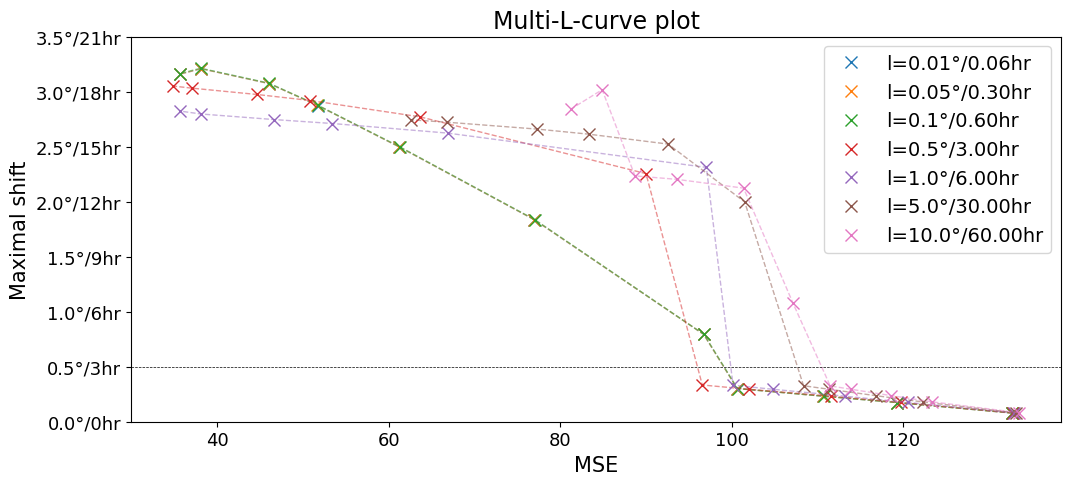

In [ ]:
multi_L_curve(ls, ss, mses, maxhs, "ruthenium")
display(Markdown(f"### This plot shows the multi-L-curve plot for the provided grid of length-scale and output-scale values."))

Given the multi-L-curve plot, the user can choose the candidate points and analyze them. Lets' say that we choose l=0.5°/3.00hr and $\sigma=0.01$. This solution was found in the above inversion or can be uploaded from 'results/Ruthenium/results_l05_s001.h5'.

In [5]:
#you can load the solution using this code cell

with h5py.File("results/Ruthenium/results_l05_s001.h5", "r") as f: 
    z = f["source"][:]
    hh = f["hh"][:]
    hv = f["hv"][:]
    ht = f["ht"][:]

bc_posterior.mu_h = torch.tensor(hh, dtype = torch.float64).reshape(-1)
bc_posterior.mu_v = torch.tensor(hv, dtype = torch.float64).reshape(-1)
bc_posterior.mu_t = torch.tensor(ht, dtype = torch.float64).reshape(-1)
source.hat_x = torch.tensor(z, dtype = torch.float64).reshape(-1)

### This plot shows the time profile of the source term.

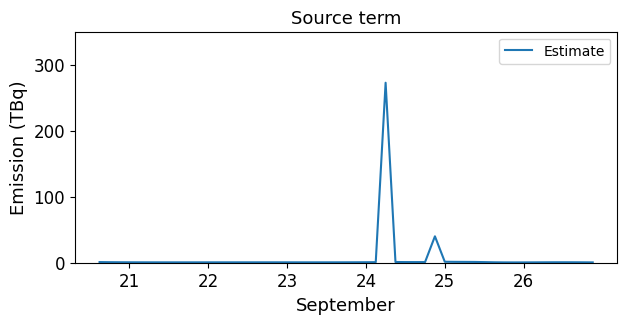

In [11]:
plot_source(source.hat_x, "ruthenium")
display(Markdown(f"### This plot shows the time profile of the source term."))

### This plot shows the linear-scale scatter plot of the predicted concentrations vs measurements. It also includes the $R^2$ and final MSE.

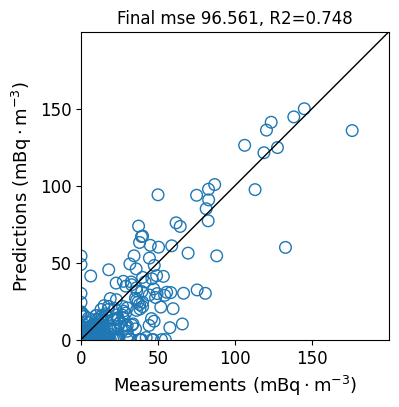

In [12]:
y_pred = bc_posterior.predict_y(source.hat_x, sc = inv_data.coef)
plot_scatter_linear(inp_data.y, y_pred, "ruthenium")
display(Markdown(fr"### This plot shows the linear-scale scatter plot of the predicted concentrations vs measurements. It also includes the $R^2$ and final MSE."))

### This plot shows the logarithmic-scale scatter plot of the predicted concentrations vs measurements with values smaller than $10^-8$ set to this value.

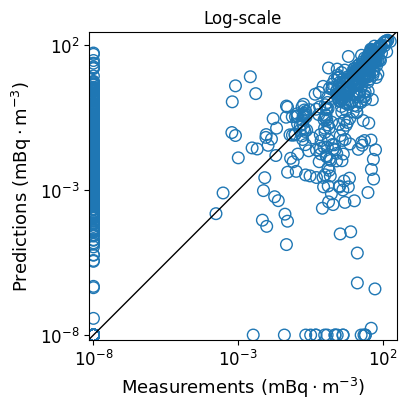

In [13]:
plot_scatter_log(inp_data.y, y_pred, "ruthenium")
display(Markdown(fr"### This plot shows the logarithmic-scale scatter plot of the predicted concentrations vs measurements with values smaller than $10^{-8}$ set to this value."))

## Prediction of shifts in new locations
The GP prior allows us to predict shifts in any space-time location inside the studied domain. The measurement with largest prediction starts on 26.9. at 0:00 and ends 30.9. at 24:00, so we will predict shifts for this time interval over a grid in RUssian spanning 58°E - 62°E in longitude and 53°N - 57°N in latitude.

In [6]:
min_lon2 = 58
min_lat2 = 53
max_lon2 = 62
max_lat2 = 57


start = 440-60/3
time_start = np.arange(start, start+2*20+1, 20)
time_end = np.arange(start+120/3, start+120/3+2*20+1, 20)
times_pred = np.concat((time_start.reshape(3,1), time_end.reshape(3,1)), axis = 1)

21 steps in logintude
21 steps in latitude


### This plot shows the predicted shifts of the concentration field for time interval 26.9. - 30.9..

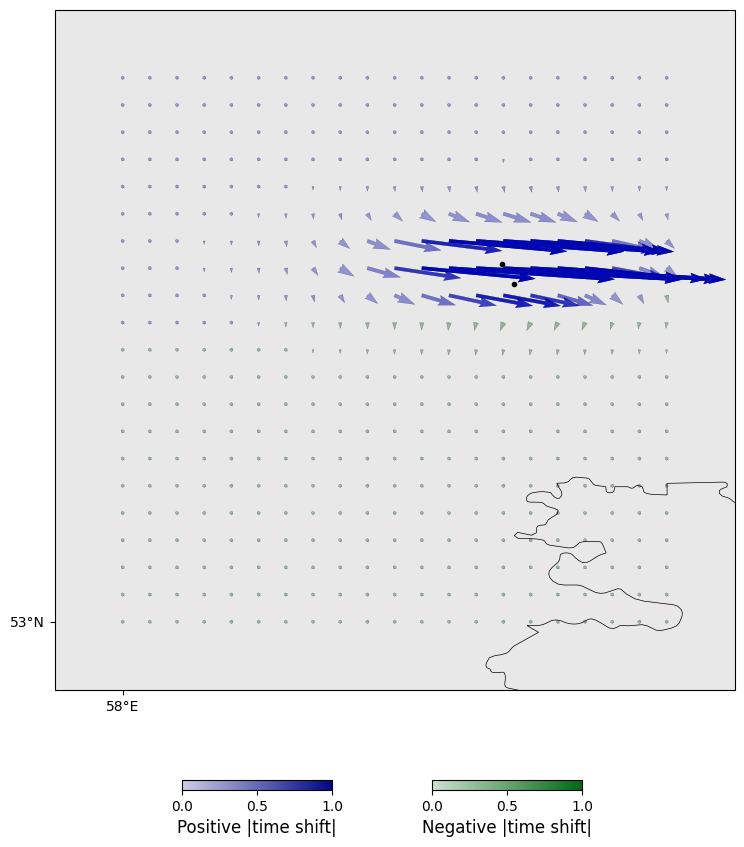

In [7]:
scale = 10 #scale parameter for better visibility of arrows

lon_min = 58
lon_max = 62
lat_min = 53
lat_max = 57
start = 440-60/3
time_start = np.arange(start, start+2*20+1, 20)
time_end = np.arange(start+120/3, start+120/3+2*20+1, 20)
time_ints = np.concat((time_start.reshape(3,1), time_end.reshape(3,1)), axis = 1)
xstar, x_star_normed = prediction_data(lon_min, lat_min, lon_max, lat_max, time_ints, lon_lat_scaler, time_scaler, stepsize = 0.2) 
hs_pred = predict_shifts(bc_prior, bc_posterior, train_X, x_star_normed, same_lengthscale=False)
plot_predicted_shifts(inp_data, np.array([440, 440+40]), lon_min, lon_max, lat_min, lat_max, xstar, hs_pred, (bc_posterior.shvt[2]*bc_posterior.mu_t).detach().numpy(), scale)
display(Markdown(fr"### This plot shows the predicted shifts of the concentration field for time interval 26.9. - 30.9.."))